# Mathematical Modeling Project 3
## Semiconductor Wafer Production Queuing Model
### By: James Tourkistas

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import random 
import pandas as pd

### Poisson Draws for Daily Wafer Orders
**$\begin{align}P\left( k \right) = \frac{{e^{ - \lambda } \lambda ^k }}{{x!}}\end{align}$**

$\begin{align}Parameter:\end{align}$
$\begin{align}\lambda=u*\frac{AnnualProductionCapacity}{DaysInYear}\end{align}$


In [2]:
# copy custom Pvar function from pvar.ipynb
###Single Poisson Draws. Pick lambda
def Pvar(mu): 
    '''    
    Args: 
        mu :    mean of Poisson random variate 
        
    Returns: 
        Poisson random variate with mean mu
    '''
    
    r = np.random.uniform()    # number from uniform distribution [0,1)
    p = np.exp(-mu)            # Poisson probability
    ptot = p                   # will accumulate the probability variate <= k
    k = 0                      # trial variate
    
    while r > ptot: 
        k += 1
        p = p * mu / k         # probability of k + 1 using the recursive relation 
        ptot += p
    
    return k

#### Note: Formulation of poisson draws from Mathematical Modeling class. 

### Multinomial Draws (Order Type Breakdown)

#### Demand Probabilities by Producible Chip Size:
#### (See Calculations Below)
**5nm:**.02

**7nm:**.17

**10nm:**.002

**16nm:**.20

**20nm:**.009

**28nm**:.21

**40/45nm**:.18

**65nm:**.13

**90nm:**.07


In [3]:
####Stochastic Daily Demand Draws

def multinomial_order_type(n):
    
    '''    
    Args: 
        n :    number of orders for period 
    
    returns breakdown by order type
    '''
    order_prob=np.array([0.02170595, 0.17131066, 0.00230304, 0.20148758, 0.00931966,
       0.20950821, 0.18398519, 0.12817502, 0.0722047 ])  ###See Calculation Below
    orders_dict={"5nm":0,"7nm":0,"10nm":0,"16nm":0,"20nm":0,"28nm":0,"40/45nm":0,"65nm":0,"90nm":0}
    daily_orders=[]
    
    for i in range(n):
        unif=np.random.rand(1)
        if unif<np.sum(order_prob[:1]):
            daily_orders.append("5nm")
        elif unif<np.sum(order_prob[:2]):
            daily_orders.append("7nm")
        elif unif<np.sum(order_prob[:3]):
            daily_orders.append("10nm")
        elif unif<np.sum(order_prob[:4]):
            daily_orders.append("16nm")
        elif unif<np.sum(order_prob[:5]):
            daily_orders.append("20nm")
        elif unif<np.sum(order_prob[:6]):
            daily_orders.append("28nm")
        elif unif<np.sum(order_prob[:7]):
            daily_orders.append("40/45nm")
        elif unif<np.sum(order_prob[:8]):
            daily_orders.append("65nm")
        else:
            daily_orders.append("90nm")
    
    ###Add Random Draws to Dictionary d
    d = {x:daily_orders.count(x) for x in daily_orders}
    
    ###Add 0 to dictionary for chips without orders
    for k in d.keys():
        orders_dict[k]=d[k]
        
    return orders_dict 
#pd.DataFrame(pd.DataFrame(demand_vec)[0].value_counts()).reset_index()



### Set Parameters:

**$\begin{align}tmax:\end{align}$** days to run model.

**$\begin{align}qmax:\end{align}$** vector representing maximum queued orders allowed for machine.

**$\begin{align}Wafers Per Day:\end{align}$** vector representing average # of wafers produced per day by each machine type.

**$\begin{align}nmachines:\end{align}$** number of different wafer type machines

 $\begin{align}u:\end{align}$ fab capacity utilization parameter between 0 and 1 depending on average plant capacity used.
 

In [4]:
###Initial Variables
# Set Up Parameters for Model. 
nmachines = 9  ###Machines Types
tmax=10  ###Days Model Run For
col_nams=["5nm","7nm","10nm","16nm","20nm","28nm","40/45nm","65nm","90nm"]   ###Types of Wafers Produced
qmax=np.array([2,3,2,2,100,100,100,100,100]) ###Maximum orders for each machine type
wafers_per_day=np.array([5,10,15,30,50,70,60,100,500]) ##Maximum daily processing capacity for each machine


### Multiple Machine Capacity Queuing Model: 


In [5]:
###Initialize Variables to 0
total_orders=0
idle=0
idle_list=[]
lost=0
wait=0
wait_list=[]
t=0
q=[] #an empty queue
lost_orders=[]
machines=np.zeros((nmachines,1)) # all machines free to start
q = [[] for _ in range(nmachines)]# each machine's queue starts empty,
df = pd.DataFrame(columns=col_nams)
u=1
###RUN MODEL

while t < tmax:
    
    t=t+1 # first, let time pass
    
    new_orders=Pvar(u*(120000/365))  ##New Orders drawn from Poisson Distribution
    
    total_orders=total_orders+new_orders  ###Order Tally
    
    orders_dict=multinomial_order_type(new_orders) ###Order Breakdown from Multinomial Distribution
    
    df = df.append(orders_dict, ignore_index = True)  ###Append New Orders To Table
    
    ###Create an array with order counts
    
    wafer_breakdown=np.array([orders_dict["5nm"],orders_dict["7nm"],orders_dict["10nm"],orders_dict["16nm"],orders_dict["20nm"],orders_dict["28nm"],orders_dict["40/45nm"],orders_dict["65nm"],orders_dict["90nm"]])
    
    ####ADD NEW ORDERS TO MACHINE QUEUE
    
    for k in range(nmachines):
        
        if len(q[k]) < qmax[k]: # Check Machine Queue.  
            q[k].append([t,wafer_breakdown[k]]) # [time of arrival, time to complete] Service time follows a shifted Poisson distribution
    
        ###REFUSE ORDERS EXCEEDING MAXIMUM CAPACITY for MACHINE
        
        else:
            lost_orders.append(col_nams[k])
            lost_orders.append(wafer_breakdown[k])
            lost=lost+1 
    
    ###ROUTE ORDERS TO MACHINE AND COMPLETE ORDERS
    
    for i in range(nmachines):
            
        if machines[i] >= wafers_per_day[i]:
            machines[i]-=wafers_per_day[i] #If queued order is above wafer per day capacity, reduce by capacity
        
        elif machines[i]< wafers_per_day[i]:
            
            qlength = len(q[i])
            
            if qlength > 0:
                
                ###REMOVE ORDER(S) FROM QUEUE TO UTILIZE EXCESS MACHINE CAPACITY 
                wt=t-q[i][0][0] ###Calculate Wait Time From Earliest Order. 
                wait_list.append(col_nams[i])
                wait_list.append(wt)
                wait +=wt  
                b=qlength*2+1
                extra_capacity=wafers_per_day[i]-machines[i]
                arr=np.hstack(q[i])[1:b:2]   ####Retrieve Only Order Values
                index=np.sum(np.cumsum(arr)<=extra_capacity) ####Find Index Greater Than Given Capacity
                ind_plus=index+1
                machines[i]=np.sum(arr[0:ind_plus])-extra_capacity ###Add Incomplete Portion of Order to Machine
              
                ##Set negative to 0
                if machines[i]<0:
                    idlt=1-((-machines[i])/wafers_per_day[i]) ##Calculate idle time
                    idle_list.append(col_nams[i])
                    idle_list.append(idlt[0])
                    idle=idle+idlt ###Add Idle Time To Idle
                    machines[i]=0 ####Set q to 0 if extra capacity exceeds orders in queue
                
                
                q[i]=q[i][ind_plus:][:] ###Remove orders from queue
                
            else: 
                q[i] = []  #IF ALL QUEUED JOBS COMPLETE, SET QUEUE TO NO ORDER STATUS
                idlt=1-(machines[i]/wafers_per_day[i]) ##Calculate idle time
                idle_list.append(col_nams[i])
                idle_list.append(idlt[0])
                idle=idle+idlt  ###Add Idle Time To Idle
                machines[i]=0
                
                
##### AT END OF TIME COUNT LOST JOBS
for i in range(nmachines): 
    lost += len(q[i]);  # Orders Remaining At End of Period Are Lost 
    m=len(q[i])*2+1
    if m>1:
        lost_orders.append(col_nams[i])
        lost_orders.append(np.sum(np.hstack(q[i])[1:m:2])) ###Add Left Over Orders to Lost Orders
        
wait = wait/(total_orders-lost);  # average wait of those who joined the queue 

print('Total Orders:', total_orders)
print('Wait Time:', wait)
print('Machine Idle Time:', idle[0])
print('Incomplete Orders:', lost)

###Calculate Completed and Missed Orders for Each Category
if len(lost_orders)>0:
    lost_orders_df=pd.DataFrame(columns=["lost_order_quantity","type"])
    lost_orders_df["type"]=lost_orders[0::2]
    lost_orders_df["lost_order_quantity"]=lost_orders[1::2]
    lo=lost_orders_df.groupby("type")["lost_order_quantity"].sum()
    


Total Orders: 3279
Wait Time: 0.004595588235294118
Machine Idle Time: 13.785047619047615
Incomplete Orders: 15


**Note:** Each order includes multiple wafers of the same type. 

### Idle Time  Breakdown by Machine

In [6]:
###Calculate Idle Machine Time for Each Category

idletime_df=pd.DataFrame(columns=["idle_time","type"])
idletime_df["type"]=idle_list[0::2]
idletime_df["idle_time"]=idle_list[1::2]
it=idletime_df.groupby("type")["idle_time"].sum()

### Total Wait Time  by Machine

In [7]:
waittime_df=pd.DataFrame(columns=["wait_time","type"])
waittime_df["type"]=wait_list[0::2]
waittime_df["wait_time"]=wait_list[1::2]
wt2=waittime_df.groupby("type")["wait_time"].sum()

### Final Wafer Breakdown: Completed vs Missed Orders

In [8]:
order_stats=pd.DataFrame(df.sum(axis=0))
order_stats=order_stats.join(pd.DataFrame(lo)).fillna(0)
order_stats=order_stats.join(pd.DataFrame(it)).fillna(0)
order_stats=order_stats.join(pd.DataFrame(wt2)).fillna(0)
order_stats.columns = ['Possible Wafer Orders', 'Missed Orders',"Idle Time","Total Wait"]
order_stats["Completed Wafers"]=order_stats['Possible Wafer Orders']-order_stats['Missed Orders']
Unit_Price_Breakdown=np.array([16988,9346,5992,3984,3677,2891,2274,1937,1650])
#See Kahn at 44.
order_stats["Est. Sale Price ($)"]=Unit_Price_Breakdown
order_stats["Period Revenue ($)"]=order_stats["Est. Sale Price ($)"]*order_stats["Completed Wafers"]

order_stats

,Possible Wafer Orders,Missed Orders,Idle Time,Total Wait,Completed Wafers,Est. Sale Price ($),Period Revenue ($)
5nm,66.0,14.0,0.800000,3,52.0,16988,883376.0
7nm,575.0,467.0,0.000000,3,108.0,9346,1009368.0
10nm,16.0,0.0,1.066667,0,16.0,5992,95872.0
16nm,661.0,299.0,0.000000,9,362.0,3984,1442208.0
20nm,42.0,0.0,0.840000,0,42.0,3677,154434.0
28nm,694.0,0.0,2.885714,0,694.0,2891,2006354.0
40/45nm,569.0,0.0,3.416667,0,569.0,2274,1293906.0
65nm,433.0,0.0,4.330000,0,433.0,1937,838721.0
90nm,223.0,0.0,0.446000,0,223.0,1650,367950.0


In [9]:
order_stats2=order_stats.reset_index()

### Plots

Text(0, 0.5, 'Missed Orders')

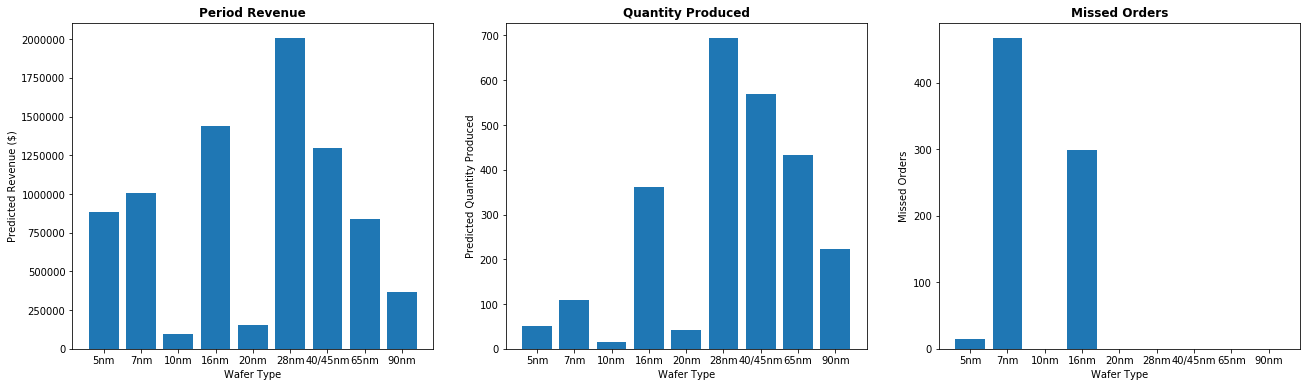

In [10]:
plt.figure(figsize=(22,6))
plt.subplot(1, 3, 1)
plt.title('Period Revenue', fontweight="bold")

plt.bar(order_stats2["index"],order_stats2["Period Revenue ($)"])

plt.xlabel('Wafer Type')
plt.ylabel('Predicted Revenue ($)')


plt.subplot(1, 3, 2)
plt.title('Quantity Produced', fontweight="bold")

plt.bar(order_stats2["index"],order_stats2["Completed Wafers"])
plt.xlabel('Wafer Type')
plt.ylabel('Predicted Quantity Produced')

plt.subplot(1, 3, 3)
plt.title('Missed Orders', fontweight="bold")

plt.bar(order_stats2["index"],order_stats2['Missed Orders'])
plt.xlabel('Wafer Type')
plt.ylabel('Missed Orders')



Text(0, 0.5, 'Summed Idle Time')

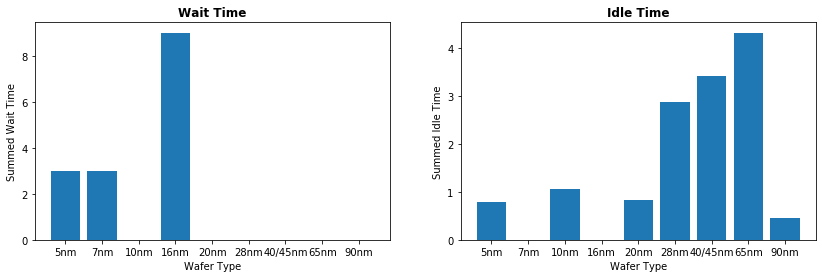

In [11]:
plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.title('Wait Time', fontweight="bold")

plt.bar(order_stats2["index"],order_stats2["Total Wait"])

plt.xlabel('Wafer Type')
plt.ylabel('Summed Wait Time')


plt.subplot(1, 2, 2)
plt.title('Idle Time', fontweight="bold")

plt.bar(order_stats2["index"],order_stats2["Idle Time"])
plt.xlabel('Wafer Type')
plt.ylabel('Summed Idle Time')

In [12]:
print(f"Estimated Revenue from Sales Over Period ({tmax} days):$", sum(order_stats["Period Revenue ($)"]))

Estimated Revenue from Sales Over Period (10 days):$ 8092189.0


### Calculations: Demand Probability by Chip Type for Multinomial Draws 
The model draws its inspiration from Taiwan Semiconductor Manufacturing Company (TSMC). TSMC currently runs "four 12-inch wafer GIGAFAB® fabs, four 8-inch wafer fabs, one 6-inch wafer fab, one 12-inch wafer fab, and two 8-inch wafer fabs. They plan to build a new 5nm fab in Arizona with 20,000 semiconductor wafers per month. TSMC's total wafer production capacity is 12,000,0000 12 inch equivilant wafers. TSMC 2020 Annual Report. Since they are such a large wafer company, we assumed their sales would be representative of demand. 

In [13]:
# TSMC Revenue Breakdown: From TSCM Quarterly Presentation Q1 2021

#5nm,7nm,10nm,16nm,20nm,28nm,40/45nm,65nm,90nm,.11/.13um, .15/.18um,.25um+
##Revenue Percents
Q1_2021=np.array([.14,.35,0,.14,0,.11,.07,.05,.03,.03,.06,.02])
###Wafer Shipment
Q4_2020=np.array([.20,.29,0,.13,.01,.11,.08,.05,.02,.03,.07,.01])
Q3_2020=np.array([.14,.35,0,.14,0,.11,.07,.05,.03,.03,.06,.02])
Q1_2021



array([0.14, 0.35, 0.  , 0.14, 0.  , 0.11, 0.07, 0.05, 0.03, 0.03, 0.06,
       0.02])

In [14]:
###2020 Revenue Breakdown 

#5nm,7nm,10nm,16nm,20nm,28nm,40/45nm,65nm,90nm, .11/.13um, .15/.18um,.25um+
all_rev_breakdown=np.array([90934485,394836964,3403151,197959003,8450865,149367729,103176542,61226671,29380358,33197137,86008475,20514893])

###5nm,7nm,10nm,16nm,20nm,28nm,40/45nm,65nm,90nm
NM_Rev_Breakdown=np.array([90934485,394836964,3403151,197959003,8450865,149367729,103176542,61226671,29380358])

#See TSMC 2020 Annual Report at 52.

Unit_Price_Breakdown=np.array([16988,9346,5992,3984,3677,2891,2274,1937,1650])

#See Kahn at 44.

#### TSMC did not report category price so we divided reported revenue by projected prices from Kahn paper. 

In [15]:
###5nm,7nm,10nm,16nm,20nm,28nm,40/45nm,65nm,90nm
Q_Breakdown=NM_Rev_Breakdown/Unit_Price_Breakdown
Q_Breakdown

array([ 5352.86584648, 42246.62572223,   567.9490988 , 49688.50476908,
        2298.30432418, 51666.45762712, 45372.2700088 , 31609.01961797,
       17806.27757576])

#### Probabilities Used for Multinomial Model


$\begin{align}p_i=\frac{\frac{c_i}{\pi_i}}{\sum_{i=1}^{i}(\frac{c_i}{\pi_i})}\end{align}$

**c:** annual chip type revenue

**π:** average chip type price

In [16]:
###5nm,7nm,10nm,16nm,20nm,28nm,40/45nm,65nm,90nm
#Normalized
Q_Probability=Q_Breakdown/np.sum(Q_Breakdown)
Q_Probability

array([0.02170595, 0.17131066, 0.00230304, 0.20148758, 0.00931966,
       0.20950821, 0.18398519, 0.12817502, 0.0722047 ])

**References:**

1) McClean, E. 2018. Advanced Technology Key to Strong Foundry Revenue per Wafer. [online] IC Insights. Available at: <https://www.icinsights.com/data/articles/documents/1108.pdf> [Accessed 4 May 2021].

2) Kahn, S et al. 2020. AI Chips: What They Are and Why They Matter. [online] Georgetown Center for Security and Emerging Technology. Available at: <https://cset.georgetown.edu/research/ai-chips-what-they-are-and-why-they-matter> [Accessed 4 May 2021]. https://doi.org/10.51593/20190014

3) McClean, E. 2018. Revenue per Wafer Climbs As Demand Surges for 5nm/7nm IC Processes. [online] IC Insights. Available at: <https://www.icinsights.com/data/articles/documents/1350.pdf> [Accessed 4 May 2021].

4) Zafar, R. 2019. Apple A13 & Beyond: How Transistor Count And Costs Will Go Up. [online] wccftech. Available at: <https://wccftech.com/apple-5nm-3nm-cost-transistors/> [Accessed 4 May 2021].


5) Su, Jeff. April 2021. TSMC Quarterly Management Report. [online] TSMC. Available at: <https://investor.tsmc.com/english/encrypt/files/encrypt_file/reports/2021-04/c3503e3be4f98cd83817a8abff6e4586deaa3904/1Q21ManagementReport.pdf> [Accessed 5 May 2021].

6) TSMC. 2020. TSMC Annual Report. [online] TSMC. Available at: <ttps://investor.tsmc.com/sites/ir/annual-report/2020/2020Annual%20Report_E_%20.pdf> [Accessed 5 May 2021].

#### Note: Code was created by adapting Math Modeling module multiserver queueing materials.

## Deterministic Model (Still Under Construction):

In [17]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from collections import Counter

In [18]:
###TSMC Price Per 300mm Wafer by Feature Size

nm5=16746
nm7=9213
nm10=5907
nm12_16=3927
###Initial Inventory Capacity
u=1  ####Utilization
c=120000  #approximate quantity sold 30000 per month.
##Other Parameters

K_hat=-5400000000 ###Capital Investment
L=3000*164000  ### Annual Labor (Employees*Avg Salary)

K=(1000000000-L)  #### Non-Labor Operating Expenses
I_0=K_hat  #### Initial Profits
Q_0=u*c 
R_0=0
###Initial Inventory Capacity
p=nm5 #2019 sales for TSMC foundary
r=q*p

#u=np.random.uniform(.5,1,6)

In [19]:
###Semiconductor Model
t=np.linspace(0,5,6)
x_0=[Q_0,R_0,I_0]
def SM(x,t):
    Q,R,I = x
    dxSM= np.zeros(3)
    dxSM[0]=0 #Q
    dxSM[1]=Q*p-R #R 
    dxSM[2]=Q*p-L-K #I(ROI)
    return dxSM




In [20]:
####ODE INT METHOD (allows for multidimensional matrix)
sol_SM=odeint(SM,x_0,t)
t



array([0., 1., 2., 3., 4., 5.])

In [21]:
###Get Model Predictions
Q_Pred=sol_SM[:,0]
R_Pred=sol_SM[:,1]
I_Pred=sol_SM[:,2]

<Figure size 576x576 with 0 Axes>

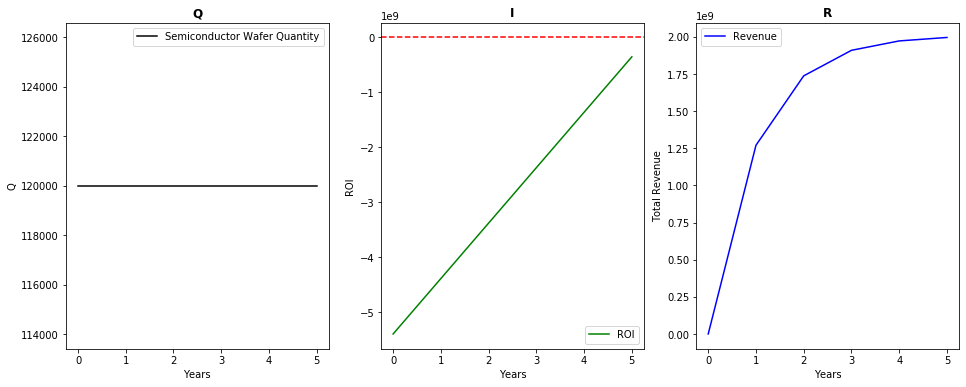

In [22]:
plt.figure(figsize=(8,8))
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.title('Q', fontweight="bold")

plt.plot(t,Q_Pred, color="black", label='Semiconductor Wafer Quantity')

plt.xlabel('Years')
plt.ylabel('Q')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('I', fontweight="bold")

plt.plot(t,I_Pred, color="green", label='ROI')
plt.axhline(y=0, color="red", linestyle='--')
plt.xlabel('Years')
plt.ylabel('ROI')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('R', fontweight="bold")

plt.plot(t,R_Pred, color="blue", label='Revenue')

plt.xlabel('Years')
plt.ylabel('Total Revenue')
plt.legend()

####Note: It takes a year to get up to full capacity. 